In [ ]:
# Install dependencies required
!pip install torchvision


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchvision
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
import PIL.Image as Image
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

In [ ]:
# Library for accessing google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = "/content/drive/MyDrive/TA-GROUP11/DATASET"
train_dir = data_dir + "/DATA_TRAINING"
valid_dir = data_dir + "/DATA_VALID"
diseases = os.listdir(train_dir)
diseases

['Training_GLS', 'Training_HL', 'Training_Rust', 'Training_NLB']

In [ ]:
# Define our classes first
__classes = ['Training_GLS', 'Training_HL', 'Training_NLB', 'Training_Rust']
__classes


['Training_GLS', 'Training_HL', 'Training_NLB', 'Training_Rust']

In [ ]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) # Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Training_GLS,1651
Training_HL,1858
Training_Rust,1916
Training_NLB,1907


In [ ]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 

In [ ]:
# check our train shape
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [ ]:
# total number of classes in train set
len(train.classes)

4

In [ ]:
# check our train shape
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [ ]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [ ]:
# setting the batch size
batch_size = 32

In [ ]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)
# print(list(train_dl))

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Let's CHeck device
torch.device(2)

device(type='cuda', index=2)

In [ ]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Try to check our device
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


In [ ]:
# Helper --For--Remove
# print(train_dl.__iter__()[0][0])
print(train_dl.__len__())

230


In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [ ]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        

In [ ]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [ ]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model = torch.load('/content/drive/MyDrive/TA-GROUP11/Model/plant-disease-model-complete5.pth')
model.eval()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
test_dir = '/content/drive/MyDrive/TA-GROUP11/DATASET'
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [ ]:
test_images = sorted(os.listdir(test_dir +'/DATA_TESTING' )) # since images in test folder are in alphabetical order

In [ ]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    print("Data type =",type(xb))
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    print("Prediksi :",torch.max(yb, dim=1))
    return train.classes[preds[0].item()]

In [ ]:
def predict_image2(img,model):
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  _,preds =  torch.max(yb,dim=1)
  percentage = torch.nn.functional.softmax(yb, dim=1)[0] * 100
  #
  # Print the name along with score of the object identified by the model
  #
  labels = __classes
  print(labels[preds[0]], round(percentage[preds[0]].item(),2))
  #
  # Print the top 5 scores along with the image label. Sort function is invoked on the torch to sort the scores.
  #
  _, indices = torch.sort(yb, descending=True)
  result = [(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]
  return labels[preds[0]], round(percentage[preds[0]].item(),2);

Saving corn-gls.jpeg to corn-gls.jpeg
RGB
Training_NLB 71.17


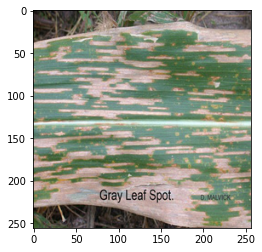

In [ ]:
from PIL import Image
from google.colab import files
import cv2
uploaded = files.upload()
label = str(list(uploaded.keys())[0])
path = '/content/' + label
def getFilenameFileExtension(path):
  longFileName,fileExtension = path.split('.',2)
  filename = [s for s in longFileName.split('/')][-1]
  return filename,fileExtension

# img = Image.open(path).convert('L').resize((28, 28), Image.ANTIALIAS)
img = Image.open(path)
if img.mode == 'RGBA':
  filename,fileextension = getFilenameFileExtension(path)
  img.load()
  background = Image.new("RGB", img.size, (255, 255, 255))
  background.paste(img, mask = img.split()[3])
  background.save(filename+'.'+'JPG', "JPEG", quality=100)
  print(background.mode)
  img = Image.open(filename+'.'+'JPG')
# Convert and reshape
print(img.mode)
img.convert('RGB')
img = img.resize((256, 256), Image.ANTIALIAS)


# img = np.array(img)

# Convert to tensor
# Define a transform to convert the image to tensor
transform = transforms.ToTensor()

# Convert the image to PyTorch tensor
img = transform(img)
predict_image2(img,model)
plt.imshow(img.permute(1, 2, 0))

## Test Val Image


In [ ]:
# print(sub_fol)

['Valid_Rust']


In [ ]:
# getting all predictions (actual label vs predicted)
%%capture cap --no-stderr
test_valid = '/content/drive/MyDrive/TA-GROUP11/DATASET/DATA_VALID'
sub_fol = os.listdir(test_valid)
# getting all predictions (actual label vs predicted)
for fol in sub_fol:
  test = ImageFolder(test_valid, transform=transforms.ToTensor())
  test_images = sorted(os.listdir(test_valid + "/" + fol )) # since images in test folder are in alphabetical order
  print("\n=========================  {}  =========================".format(fol))
  for path in test_images:
    img = Image.open('/content/drive/MyDrive/TA-GROUP11/DATASET/DATA_VALID/'+fol+'/'+path)
    if img.mode == 'RGBA':
      filename,fileextension = getFilenameFileExtension(path)
      img.load()
      background = Image.new("RGB", img.size, (255, 255, 255))
      background.paste(img, mask = img.split()[3])
      background.save(filename+'.'+'JPG', "JPEG", quality=100)
      print(background.mode)
      img = Image.open(filename+'.'+'JPG')
    # Convert and reshape
    print('Label ',path)
    img.convert('RGB')
    img = img.resize((256, 256), Image.ANTIALIAS)


    # img = np.array(img)

    # Convert to tensor
    # Define a transform to convert the image to tensor
    transform = transforms.ToTensor()

    # Convert the image to PyTorch tensor
    img = transform(img)
    predict_image2(img,model)
  print("Total Image => {}".format(len(test_images)))
  print('stuff')
  with open('output.txt', 'w') as f:
      f.write(cap.stdout)

## Validasi Accuration using Confusion Matrix

In [ ]:
import pandas as pd
#Creating a confusion matrix
from sklearn.metrics import confusion_matrix
cm_lists = list()
def confusionMatrix(nb_classes):
  nb_classes = 4
  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  # cm_df = pd.Dataframe()
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(valid_dl):
          inputs = inputs.to(device)
          classes = classes.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1

          # print(confusion_matrix)
          # get the per-class accuracy:
          # print((confusion_matrix.diag()/confusion_matrix.sum(1)).tolist())
          # cm_df.append(pd.Dataframe(list(confusion_matrix.diag()/confusion_matrix.sum(1)),ignore_index = True))
          cm_lists.append((confusion_matrix.diag()/confusion_matrix.sum(1)).tolist())
  # cm_df = pd.DataFrame(cm_lists, columns=__classes)
  return confusion_matrix.tolist()

In [ ]:
cm = confusionMatrix(4)
cm = np.array(cm, dtype=np.float32)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm
# cm_lists = confusionMatrix(4)
# cm_lists

KeyboardInterrupt: ignored

In [ ]:
import itertools
def plot_confusion_matrix(cnf_matrix, numbers_type='numbers_and_percentage', class_names=__classes, title='Confusion matrix', cmap=plt.cm.Blues, file_name='confusionmatrix.png'):
    combined = True
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = 0.8*cnf_matrix.max() / 1.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        if numbers_type == 'numbers_and_percentage':
            st1 = '{:.2f}%'.format(100 * cnf_matrix_normalized[i, j])
            st2 = '({:.2f})%'.format(cnf_matrix[i, j])
            plt.text(j, i, st1+st2,
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

        elif numbers_type == 'percentage':
            fmt = '.2f'
            plt.text(j, i, format(cnf_matrix_normalized[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        else:
            fmt = 'd'
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/content/drive/MyDrive/TA/' + file_name)

    return

In [ ]:
plot_confusion_matrix(cm)

## Testing Image

<class 'torch.Tensor'>
Data type = <class 'torch.Tensor'>
Prediksi : torch.return_types.max(
values=tensor([5.0048], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([2], device='cuda:0'))
Label: 0a11f9e8-7357-48c2-8550-daeae59a1e76___RS_NLB 3588.JPG , Predicted: Training_NLB


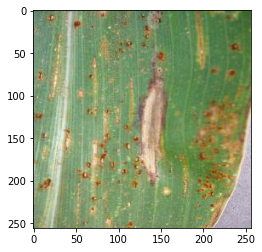

In [ ]:
# predicting first image
ti = 4
img, label = test[ti]
print(type(img))
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[ti], ', Predicted:', predict_image(img, model))

RGB
Data type = <class 'torch.Tensor'>
Prediksi : torch.return_types.max(
values=tensor([1.4100], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))
Label: 0 , Predicted: Training_GLS


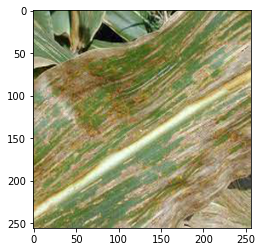

In [ ]:
from PIL import Image
from google.colab import files
import cv2
# uploaded = files.upload()
# label = str(list(uploaded.keys())[0])
# path = '/content/'+label
path = '/content/corn-gls.jpeg'
def getFilenameFileExtension(path):
  longFileName,fileExtension = path.split('.',2)
  filename = [s for s in longFileName.split('/')][-1]
  return filename,fileExtension

# img = Image.open(path).convert('L').resize((28, 28), Image.ANTIALIAS)
img = Image.open(path)

# Prerpocessing
# Convert if image mode is rgba
if img.mode == 'RGBA':
  filename,fileextension = getFilenameFileExtension(path)
  img.load()
  background = Image.new("RGB", img.size, (255, 255, 255))
  background.paste(img, mask = img.split()[3])
  background.save(filename+'.'+'JPG', "JPEG", quality=100)
  print(background.mode)
  img = Image.open(filename+'.'+'JPG')

# Convert and reshape
print(img.mode)
img.convert('RGB')
img = img.resize((256, 256), Image.ANTIALIAS)


# img = np.array(img)

# Convert to tensor
# Define a transform to convert the image to tensor
transform = transforms.ToTensor()

# Convert the image to PyTorch tensor
img = transform(img)
plt.imshow(img.permute(1, 2, 0))
print('Label:', label, ', Predicted:', predict_image(img, model))
# print(type(img))


## Serving

In [ ]:
# Install All Library
# !pip install tensorflow==2.5.0

!pip install fastapi

!pip install uvicorn

!pip install python-multipart

!pip install pillow

!pip install tensorflow-serving-api==2.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from fastapi import FastAPI, File, UploadFile
from fastapi.middleware.cors import CORSMiddleware
import uvicorn
import numpy as np
from io import BytesIO
from PIL import Image
import tensorflow as tf
import requests
app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins='*',
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

In [ ]:
def read_file_as_image(data) -> np.ndarray:
    image = np.array(Image.open(BytesIO(data)))
    return image
def getFilenameFileExtension(path):
  longFileName,fileExtension = path.split('.',2)
  filename = [s for s in longFileName.split('/')][-1]
  return filename,fileExtension

In [ ]:
@app.get('/')
def index():
    return {'message': 'This is the homepage of the API '}

@app.post("/predict")
async def predict(
    uploaded_file: UploadFile = File(...)
):
  file_location = f"/content/{uploaded_file.filename}"
  with open(file_location, "wb+") as file_object:
      file_object.write(uploaded_file.file.read())
  path = file_location
  img = Image.open(path)

  # Prerpocessing
  # Convert if image mode is rgba
  if img.mode == 'RGBA':
    filename,fileextension = getFilenameFileExtension(path)
    img.load()
    background = Image.new("RGB", img.size, (255, 255, 255))
    background.paste(img, mask = img.split()[3])
    background.save(filename+'.'+'JPG', "JPEG", quality=100)
    print(background.mode)
    img = Image.open(filename+'.'+'JPG')

  # Convert and reshape
  img.convert('RGB')
  img = img.resize((256, 256), Image.ANTIALIAS)


  # img = np.array(img)

  # Convert to tensor
  # Define a transform to convert the image to tensor
  transform = transforms.ToTensor()

  # Convert the image to PyTorch tensor
  img = transform(img)
  plt.imshow(img.permute(1, 2, 0))
  predicted,percentage = predict_image2(img,model)
  return{
      'Label' : uploaded_file.filename,
      'Predicted' : predicted,
      'Convidence' : percentage
  }


In [ ]:
# Run
!pip install colabcode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from colabcode import ColabCode
server = ColabCode(port=10000, code=False)

In [ ]:
server.run_app(app=app)

Public URL: NgrokTunnel: "https://6c51-34-83-1-95.ngrok.io" -> "http://localhost:10000"
